<a href="https://colab.research.google.com/github/IsaacFigNewton/Smishing-Detector/blob/sklearn-approach/Smishing_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

<ol>
  <li>Reimplement the TF-IDF scoring system; Score = (token TF-IDF scores from ham) - (token TF-IDF scores from spam).</li>
  <li>Use regexes to parse, score, then replace emails, phone numbers, and URLs with a dummy string for later NLP.</li>
  <li>Handle common symbol replacements and letter substitutions.</li>
  <li>Use stemming and lemmatization to reduce the TFIDF token vector space.</li>
</ol>

# Import and config

## Install packages

In [1]:
# https://sbert.net/
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
# https://github.com/MaartenGr/BERTopic
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


In [3]:
# https://github.com/filyp/autocorrect
!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=7c414180063bfa872e97131a87b0a1d00e4ff6a269786f44d130440c0add2b7e
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


## Import Libraries

In [125]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse
import re
import nltk as nlp

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import *
from sklearn.metrics.pairwise import cosine_similarity,\
                                     cosine_distances

from sklearn.cluster import KMeans,\
                            SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,\
                             VotingClassifier
from sklearn.model_selection import train_test_split


from sklearn.model_selection import train_test_split

In [5]:
from autocorrect import Speller

In [6]:
# TF-IDF
from sklearn.feature_extraction.text import CountVectorizer,\
                                            TfidfVectorizer

# Use BERT as the sentence encoder since it's the best open-source option
from sentence_transformers import SentenceTransformer

# use the bertopic text class vectorizer
from bertopic import BERTopic

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Set global variables

In [7]:
class_map = {"ham": 0, "spam": 1}
color_map = {0: "green", 1: "red"}

char_ngrams = (1, 6)
word_ngrams = (1, 3)
minSusLen = 500
lenWeight = 0.01

np.random.seed(10)
random_state = 0

## Create Models

In [83]:
# Regex for phone numbers
phone_regex = re.compile(r'(\+\d{1,2}\s?)?\(?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}')

# Regex for emails
email_regex = re.compile(r'[A-Za-z0-9. _%-]+@[A-Za-z0-9. -]+\\. [A-Za-z]{2,4}')

# Regex for URLs
url_regex = re.compile(r'https?:\/\/(www\.)?[a-zA-Z0-9.-]+\.[a-zA-Z]{2,6}(/[a-zA-Z0-9._~:/?#[\]@!$&\'()*+,;=-]*)?')

In [9]:
speller = Speller(lang="en")

In [20]:
def get_ngrams(document, word_ngram_range=(1, 3), char_ngram_range=(1, 3)):
    # Get word n-grams
    word_vectorizer = CountVectorizer(ngram_range=word_ngram_range, analyzer='word')
    word_analyzer = word_vectorizer.build_analyzer()
    word_ngrams = word_analyzer(document)

    # Get character n-grams
    char_vectorizer = CountVectorizer(ngram_range=char_ngram_range, analyzer='char')
    char_analyzer = char_vectorizer.build_analyzer()
    char_ngrams = char_analyzer(document)

    return char_ngrams + word_ngrams

In [47]:
# Load a pretrained Sentence Transformer model
# https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html#language
topic_model = BERTopic(top_n_words=15,\
                       n_gram_range=word_ngrams,\
                       min_topic_size=10,\
                       nr_topics=50,\
                       calculate_probabilities=True)

# Load a pretrained Sentence Transformer model
sentence_embedder = SentenceTransformer("all-MiniLM-L6-v2")

# create the vectorizer
vec = TfidfVectorizer(analyzer=get_ngrams,\
                      ngram_range=word_ngrams,\
                      min_df=0.001,\
                      max_df=0.9,\
                      sublinear_tf=False)

#Import and clean data

##Important Functions

In [104]:
def get_contact_counts(doc):
    # Find phone numbers
    phones = phone_regex.findall(doc)

    # Find emails
    emails = email_regex.findall(doc)

    # Find URLs
    urls = url_regex.findall(doc)

    return (len(phones), len(emails), len(urls))

In [94]:
def leet_to_english(text):
    leet_dict = {
        '0': 'o',
        '1': 'l',
        '3': 'e',
        '4': 'a',
        '5': 's',
        '7': 't',
        '8': 'b',
        '9': 'g'
    }

    # Add common leet transformations if needed
    for leet, eng in leet_dict.items():
        text = text.replace(leet, eng)

    return text

## Import, Clean data

In [118]:
# nltk.download()
corpus = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Smishing-Detector/sklearn-approach/dataset/SMSSpamCollection.txt", sep="\t", on_bad_lines='warn')

# clean the corpus
corpus = corpus.dropna(axis=0)

# rename dataset columns
corpus.columns = ["class", "text"]

# save data info for later exploration
corpus_counts = corpus["class"].value_counts()

# convert the class to a numeric value
corpus["class"] = corpus["class"].map(class_map)

# get a subset of the dataset for model testing before training on whole dataset
corpus = corpus.loc[:1000]

In [119]:
# count number of integers
corpus["num_digits"] = corpus["text"].apply(lambda s: sum(word.isdigit() for word in s.split()))

# get the number of contacts in the sms
# corpus["phone_count", "email_count", "url_count"] = corpus["text"].apply(lambda x: get_contact_counts(x))
contact_counts = corpus["text"].apply(lambda x: get_contact_counts(x))
corpus["phone_count"] = contact_counts.apply(lambda x: x[0])
corpus["email_count"] = contact_counts.apply(lambda x: x[1])
corpus["url_count"] = contact_counts.apply(lambda x: x[2])

0       (0, 0, 0)
1       (1, 0, 0)
2       (0, 0, 0)
3       (0, 0, 0)
4       (0, 0, 0)
          ...    
996     (0, 0, 0)
997     (0, 0, 0)
998     (0, 0, 0)
999     (0, 0, 0)
1000    (0, 0, 0)
Name: text, Length: 1001, dtype: object


In [120]:
# remove contact info from text, replacing it with filler
corpus["text"] = corpus["text"].apply(lambda x: re.sub(phone_regex, "phone", x))
corpus["text"] = corpus["text"].apply(lambda x: re.sub(email_regex, "email", x))
corpus["text"] = corpus["text"].apply(lambda x: re.sub(url_regex, "url", x))

# fix common leet replacements
corpus["text_with_replacements"] = corpus["text"].apply(lambda x: leet_to_english(x))

# correct spelling for better embedding
corpus["text_with_replacements"] = corpus["text_with_replacements"].apply(lambda x: speller(x))

# get the number of words in the sms
corpus["word_count"] = corpus["text_with_replacements"].apply(lambda x: len(x.split()))

# get the number of characters in the sms
corpus["char_count"] = corpus["text_with_replacements"].apply(lambda x: len(x))

# get the number of unique words in the sms
corpus["unique_word_count"] = corpus["text_with_replacements"].apply(lambda x: len(set(x.split())))

# get the number of unique characters in the sms
corpus["unique_char_count"] = corpus["text_with_replacements"].apply(lambda x: len(set(x)))

In [121]:
print(corpus.columns)

Index(['class', 'text', 'num_digits', 'phone_count', 'email_count',
       'url_count', 'text_with_replacements', 'word_count', 'char_count',
       'unique_word_count', 'unique_char_count'],
      dtype='object')


In [126]:
scaler = Normalizer()
cols_to_normalize = ["word_count", "char_count", "unique_word_count", "unique_char_count", "phone_count", "email_count", "url_count"]

# Normalize value count columns
corpus[cols_to_normalize] = scaler.fit_transform(corpus[cols_to_normalize].values)

In [127]:
# get training, test data
train, test = train_test_split(corpus, test_size=0.2)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [128]:
train.head()

,class,text,num_digits,phone_count,email_count,url_count,text_with_replacements,word_count,char_count,unique_word_count,unique_char_count
0,0,"Love isn't a decision, it's a feeling. If we c...",0,0.0,0.0,0.0,"Love isn't a decision, it's a feeling. If we c...",0.180615,0.948226,0.173089,0.195666
1,0,Oh is it? Send me the address,0,0.0,0.0,0.0,Oh is it? Send me the address,0.207778,0.860796,0.207778,0.415557
2,1,Hi. Customer Loyalty Offer:The NEW Nokia6650 M...,1,0.0,0.0,0.0,Hi. Customer Loyalty Offer:The NEW Nokia66so M...,0.165934,0.929233,0.165934,0.285407
3,0,Ho ho - big belly laugh! See ya tomo,0,0.0,0.0,0.0,Ho ho - big belly laugh! See ya tomo,0.215326,0.861303,0.215326,0.406726
4,0,"Good evening Sir, Al Salam Wahleykkum.sharing ...",0,0.0,0.0,0.0,"Good evening Sir, Al Slam Wahleykkum.sharing a...",0.145477,0.964997,0.130929,0.174572


In [124]:
test.head()

,class,text,num_digits,phone_count,email_count,url_count,text_with_replacements,word_count,char_count,unique_word_count,unique_char_count
0,0,"Fighting with the world is easy, u either win ...",0,0,0,0,"Fighting with the world is easy, u either win ...",35,150,22,24
1,0,Home so we can always chat,0,0,0,0,Home so we can always chat,6,26,6,14
2,1,URGENT! We are trying to contact U. Todays dra...,1,1,0,0,URGENT! We are trying to contact U. Today draw...,27,148,27,39
3,0,Tension ah?what machi?any problem?,0,0,0,0,Tension ah?what machi?any problem?,4,34,4,19
4,0,Got meh... When?,0,0,0,0,Got meh... When?,3,16,3,11


## Vectorize Corpus

In [130]:
# TF-IDF vectorizer
vec.fit(corpus["text_with_replacements"])
train_vects = vec.transform(train["text_with_replacements"])
test_vects = vec.transform(test["text_with_replacements"])

# BERTopic topic vectorizer
train_topics, train_probs = topic_model.fit_transform(train["text_with_replacements"])
test_topics, test_probs = topic_model.fit_transform(test["text_with_replacements"])

# BERT sentence embedder
train_embeddings = sentence_embedder.encode(train["text_with_replacements"])
test_embeddings = sentence_embedder.encode(test["text_with_replacements"])

## Get topic assignments

In [131]:
# Function to extract the number from the topic string
def extract_number(topic):
    return int(topic.split()[1])

In [132]:
train_topics_probs_df = pd.DataFrame(data = train_probs,\
                            columns=["Topic " + str(i) + " Probability" for i in range(len(set(train_topics)) - 1)]\
)

test_topics_probs_df = pd.DataFrame(data = test_probs,\
                            columns=["Topic " + str(i) + " Probability" for i in range(len(set(test_topics)) - 1)]\
)


# Ensure only numeric columns are used for finding max values and their indices
numeric_train = train_topics_probs_df.select_dtypes(include=[float, int])
numeric_test = test_topics_probs_df.select_dtypes(include=[float, int])

# Get the assigned topic, which may not exist, in which case it will be -1
train_topics_probs_df["Assigned Topic"] = pd.Series(train_topics)
# Get the topic with the highest probability for each row
train_topics_probs_df["Predicted Topic"] = numeric_train\
                                          .idxmax(axis=1, skipna=True)\
                                          .apply(extract_number)
# Get the assigned topic, which may not exist, in which case it will be -1
test_topics_probs_df["Assigned Topic"] = pd.Series(test_topics)
# Get the topic with the highest probability for each row
test_topics_probs_df["Predicted Topic"] = numeric_test\
                                          .idxmax(axis=1, skipna=True)\
                                          .apply(extract_number)

# Get the associated max probability of topic association for each row
train_topics_probs_df["Predicted Topic Probability"] = numeric_train.max(axis=1, skipna=True)
test_topics_probs_df["Predicted Topic Probability"] = numeric_test.max(axis=1, skipna=True)

# print(test_topics_probs_df.dtypes)
test_topics_probs_df.head()

,Topic 0 Probability,Topic 1 Probability,Topic 2 Probability,Assigned Topic,Predicted Topic,Predicted Topic Probability
0,2.321660e-01,0.285948,1.248608e-01,1,1,0.285948
1,1.415109e-01,0.550196,6.901776e-02,1,1,0.550196
2,7.942921e-309,1.000000,4.054615e-309,1,1,1.000000
3,3.925736e-01,0.252647,1.146775e-01,-1,0,0.392574
4,6.809642e-01,0.109188,5.982534e-02,-1,0,0.680964


## Reformat general counts, embedding and topic data

In [137]:
# Put count columns into their own sparse matrix for later concatenation
train_counts = sparse.csr_matrix(train[cols_to_normalize])
test_counts = sparse.csr_matrix(test[cols_to_normalize])

In [138]:
# Put embeddings into their own sparse matrices
train_embeddings = sparse.csr_matrix(train_embeddings)
test_embeddings = sparse.csr_matrix(test_embeddings)

In [139]:
# Get a list of shared columns between the training and testing topics
shared_topic_prob_cols = list(set(train_topics_probs_df.columns).intersection(test_topics_probs_df.columns))
print(shared_topic_prob_cols)

# convert the shared topic columns to sparse matrices
train_topics_probs = sparse.csr_matrix(train_topics_probs_df[shared_topic_prob_cols])
test_topics_probs = sparse.csr_matrix(test_topics_probs_df[shared_topic_prob_cols])

['Predicted Topic Probability', 'Topic 2 Probability', 'Predicted Topic', 'Topic 0 Probability', 'Topic 1 Probability', 'Assigned Topic']


## Combine general counts, TFIDF, sentence embeddings, and topic classifications

In [140]:
print(train_counts.shape)
print(train_vects.shape)
print(train_embeddings.shape)
print(train_topics_probs.shape)

print()
print()

print(train_counts.shape)
print(test_vects.shape)
print(test_embeddings.shape)
print(test_topics_probs.shape)

(800, 7)
(800, 8033)
(800, 384)
(800, 6)


(800, 7)
(201, 8033)
(201, 384)
(201, 6)


In [158]:
# Doing hstack directly was ineffective

# Convert sparse matrices to dense arrays
train_counts_dense = train_counts.toarray()
train_vects_dense = train_vects.toarray()
train_embeddings_dense = train_embeddings.toarray()
train_topics_probs_dense = train_topics_probs.toarray()

# Convert sparse matrices to dense arrays
test_counts_dense = test_counts.toarray()
test_vects_dense = test_vects.toarray()
test_embeddings_dense = test_embeddings.toarray()
test_topics_probs_dense = test_topics_probs.toarray()

# Horizontally stack dense arrays
all_train_embeddings_dense = np.hstack((train_counts_dense, train_vects_dense, train_embeddings_dense))#, train_topics_probs_dense))
all_test_embeddings_dense = np.hstack((test_counts_dense, test_vects_dense, test_embeddings_dense))#, test_topics_probs_dense))

# Convert back to sparse matrices
all_train_embeddings = sparse.csr_matrix(all_train_embeddings_dense)
all_test_embeddings = sparse.csr_matrix(all_test_embeddings_dense)

In [159]:
print(all_train_embeddings.shape)
print(all_test_embeddings.shape)

(800, 8424)
(201, 8424)


# Data Exploration

<Axes: xlabel='class'>

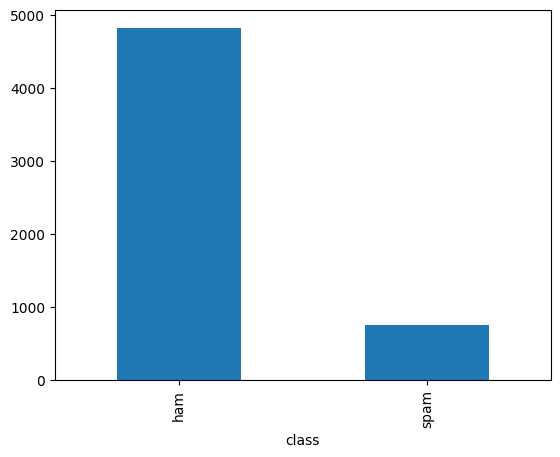

In [143]:
corpus_counts.plot.bar()

<Axes: xlabel='Predicted Topic', ylabel='Predicted Topic Probability'>

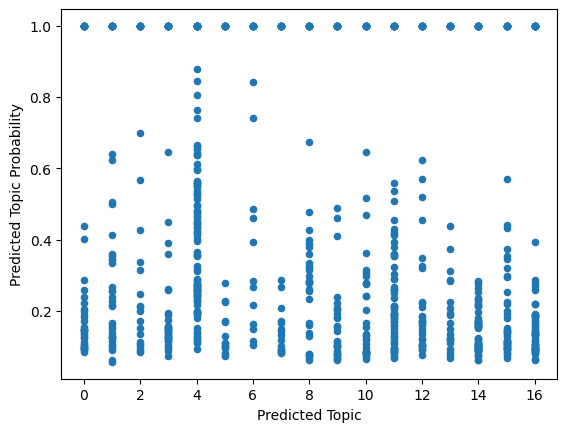

In [144]:
train_topics_probs_df.plot.scatter(x="Predicted Topic", y="Predicted Topic Probability")

<Axes: title={'center': 'Topic Frequencies'}, xlabel='Predicted Topic', ylabel='Frequency'>

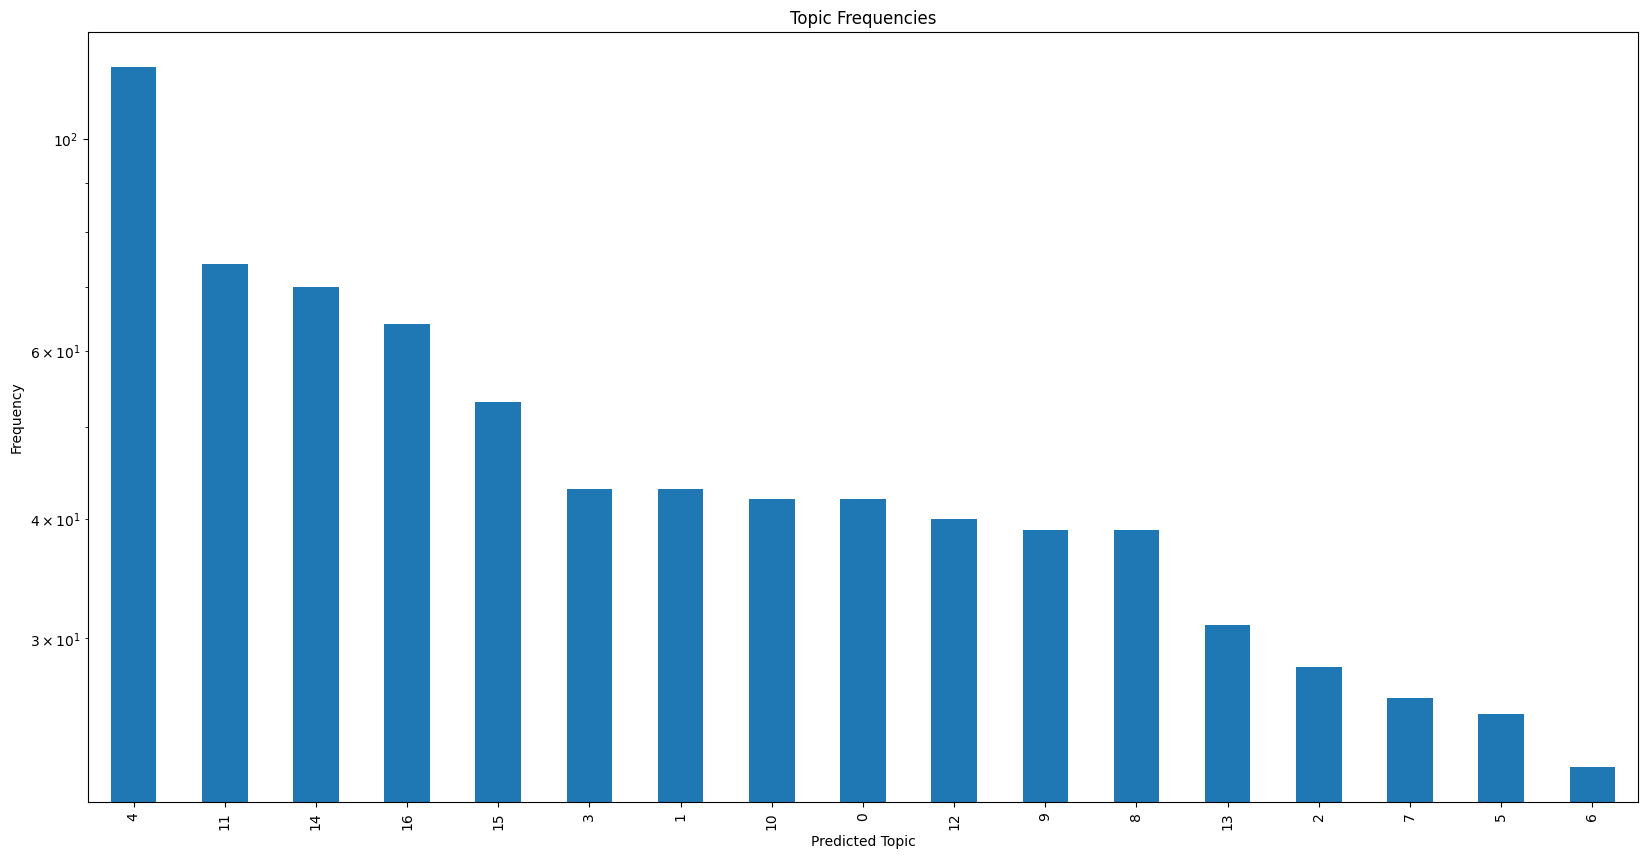

In [145]:
train_topics_probs_df["Predicted Topic"]\
  .value_counts()\
  .plot\
  .bar(logy=True, figsize=(20, 10), xlabel="Predicted Topic", ylabel="Frequency", title="Topic Frequencies")

<Axes: title={'center': 'Topic Frequencies'}, xlabel='Assigned Topic', ylabel='Frequency'>

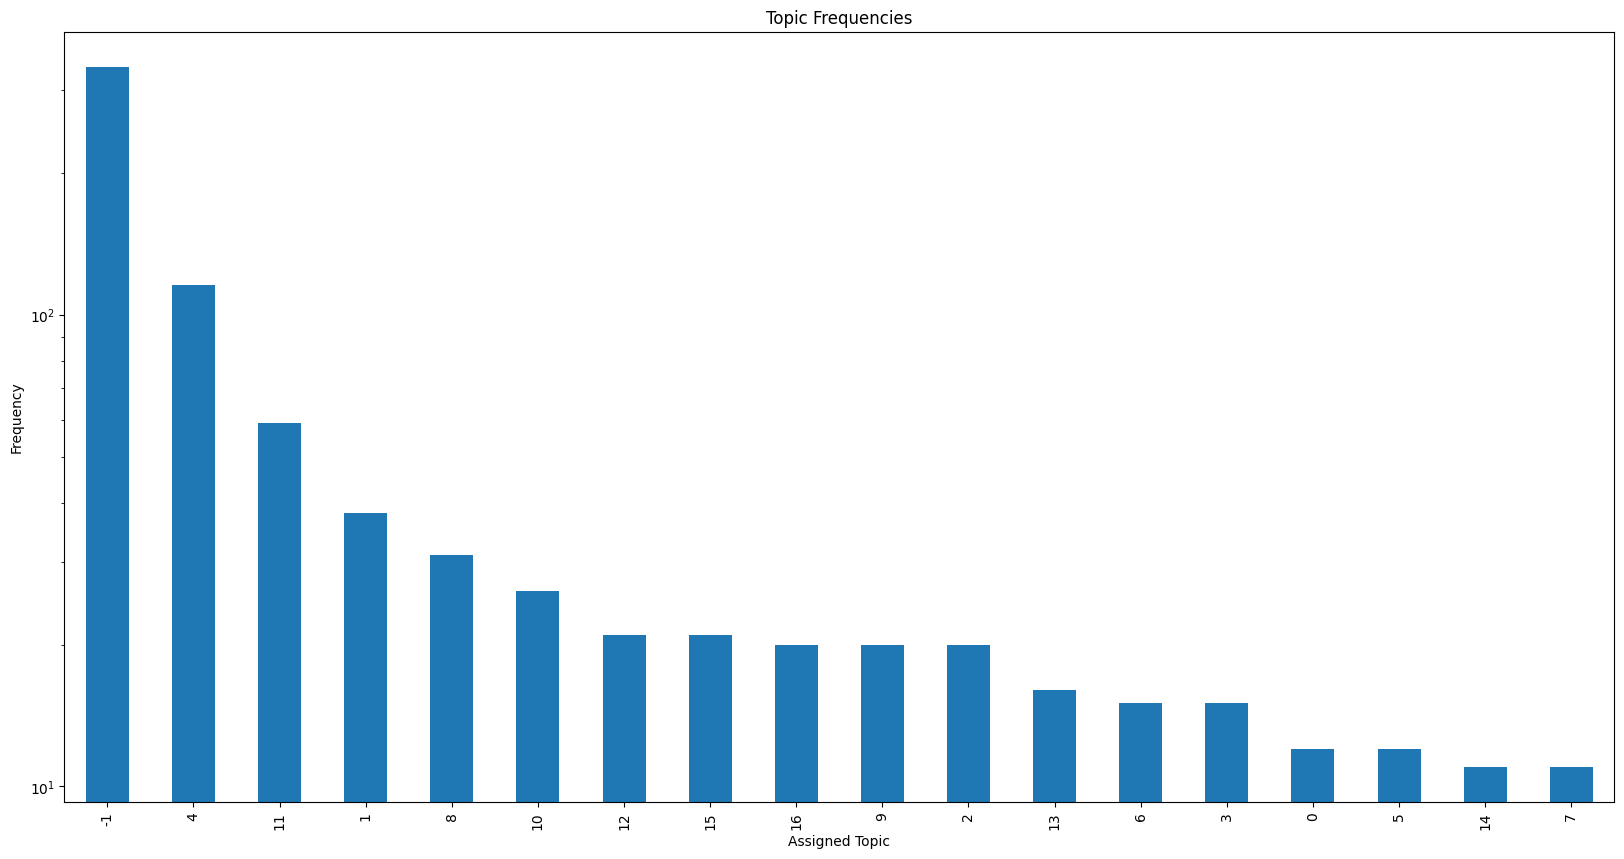

In [146]:
train_topics_probs_df["Assigned Topic"]\
  .value_counts()\
  .plot\
  .bar(logy=True, figsize=(20, 10), xlabel="Assigned Topic", ylabel="Frequency", title="Topic Frequencies")

# Classification

## Models

In [160]:
# Unsupervised
km = KMeans(n_clusters=2, random_state=random_state)
spectral = SpectralClustering(n_clusters=2, random_state=random_state)

# Supervised
knn = KNeighborsClassifier(n_neighbors=5)
nb = GaussianNB()
svc = SVC(kernel="linear")
dt = DecisionTreeClassifier()

In [161]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)

# Voting Classifier
voting = VotingClassifier(\
                        estimators=[
                          ("K-Nearest Neighbors", knn),
                          ("Naive Bayes", nb),
                          ("Support Vector", svc),
                          ("Decision Tree", dt)],
                        voting="hard")

## Important Functions

In [162]:
def get_spam_scores(training_vects, training_classes, testing_vects, testing_classes):
    baseline = [0] * len(testing_classes)
    bias = 0

   # Unsupervised
    km_predictions = pd.Series(data = km.fit_predict(testing_vects))\
                          .astype(int)

    spectral_predictions = pd.Series(data = spectral.fit_predict(testing_vects))\
                                .astype(int)


    # Supervised
    knn.fit(training_vects, training_classes)
    knn_predictions = pd.Series(data = knn.predict(testing_vects))\
                          .astype(int)

    nb.fit(training_vects.toarray(), training_classes)
    nb_predictions = pd.Series(data = knn.predict(testing_vects))\
                          .astype(int)

    svc.fit(training_vects.toarray(), training_classes)
    svc_predictions = pd.Series(data = knn.predict(testing_vects))\
                          .astype(int)

    dt.fit(training_vects.toarray(), training_classes)
    dt_predictions = pd.Series(data = knn.predict(testing_vects))\
                          .astype(int)

    # Ensemble
    rf.fit(training_vects.toarray(), training_classes)
    rf_predictions = pd.Series(data = knn.predict(testing_vects))\
                          .astype(int)

    voting.fit(training_vects.toarray(), training_classes)
    voting_predictions = pd.Series(data = knn.predict(testing_vects))\
                          .astype(int)

    # combine into 1 dataframe and cast to correct type
    scores = pd.DataFrame({
        "baseline": baseline,
        "K Means": km_predictions,
        "Spectral Clustering": spectral_predictions,
        "K Nearest Neighbor": knn_predictions,
        "Naive Bayes": nb_predictions,
        "Support Vector": svc_predictions,
        "Decision Tree": dt_predictions,
        "Random Forest": rf_predictions,
        "Voting Classifier": voting_predictions
    }).dropna()

    scores = scores.add(bias)

    scores[scores > 0.5] = 1
    scores[scores < 0.5] = 0
    return scores.astype(int)

## Classify

In [163]:
print(all_train_embeddings.shape)
print(all_test_embeddings.shape)

(800, 8424)
(201, 8424)


In [164]:
predictions = get_spam_scores(\
                              all_train_embeddings,\
                              train["class"],\
                              all_test_embeddings,\
                              test["class"]
)
predictions.head()

,baseline,K Means,Spectral Clustering,K Nearest Neighbor,Naive Bayes,Support Vector,Decision Tree,Random Forest,Voting Classifier
0,0,0,1,1,1,1,1,1,1
1,0,0,1,0,0,0,0,0,0
2,0,0,1,1,1,1,1,1,1
3,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0


In [165]:
actual = pd.DataFrame(data=corpus["class"])
actual.columns = ["actual"]
actual.head()

,actual
0,0
1,1
2,0
3,0
4,1


In [166]:
expected_and_predictions = pd.concat([actual, predictions], axis=1, ignore_index=True).dropna()
expected_and_predictions.columns = ["actual"] + list(predictions.columns)
expected_and_predictions

,actual,baseline,K Means,Spectral Clustering,K Nearest Neighbor,Naive Bayes,Support Vector,Decision Tree,Random Forest,Voting Classifier
0,0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
196,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Comparison

In [167]:
def format(stat):
    return "\t" + str('%.3f'%stat)

Decision Tree scores:
Mean Squared Error		0.289
Mean Absolute Error		0.289
False Positive Rate		0.838
False Negative Rate		0.161
Accuracy			0.711
Precision			0.162
Recall				0.182
F1				0.171


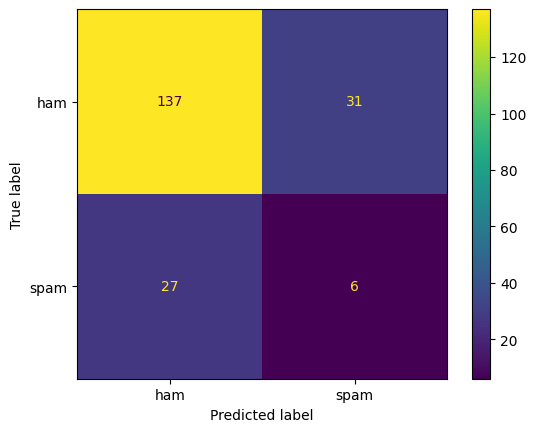


K Means scores:
Mean Squared Error		0.602
Mean Absolute Error		0.602
False Positive Rate		0.833
False Negative Rate		0.065
Accuracy			0.398
Precision			0.167
Recall				0.667
F1				0.267


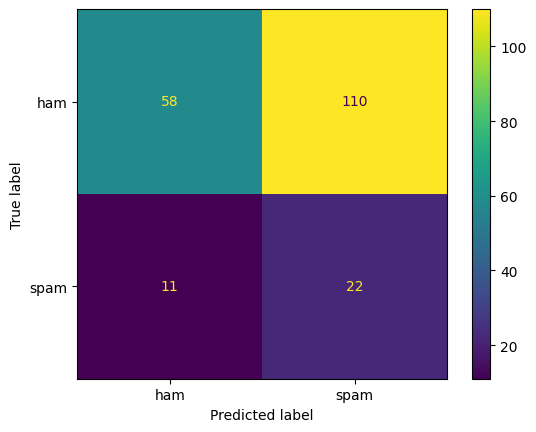


K Nearest Neighbor scores:
Mean Squared Error		0.289
Mean Absolute Error		0.289
False Positive Rate		0.838
False Negative Rate		0.161
Accuracy			0.711
Precision			0.162
Recall				0.182
F1				0.171


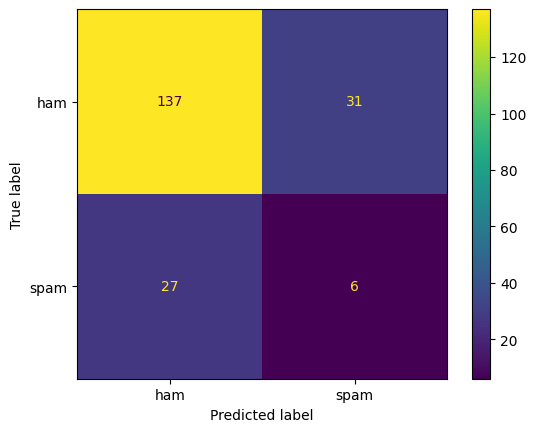


Naive Bayes scores:
Mean Squared Error		0.289
Mean Absolute Error		0.289
False Positive Rate		0.838
False Negative Rate		0.161
Accuracy			0.711
Precision			0.162
Recall				0.182
F1				0.171


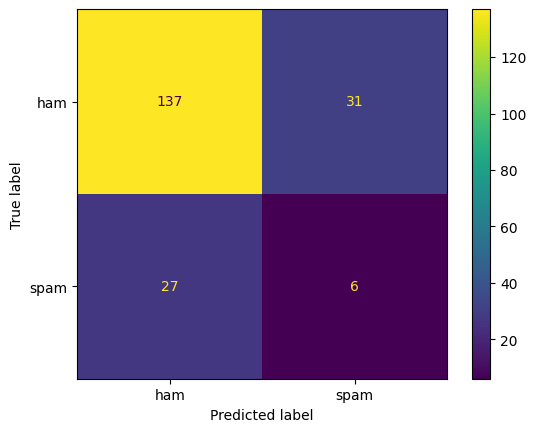


Random Forest scores:
Mean Squared Error		0.289
Mean Absolute Error		0.289
False Positive Rate		0.838
False Negative Rate		0.161
Accuracy			0.711
Precision			0.162
Recall				0.182
F1				0.171


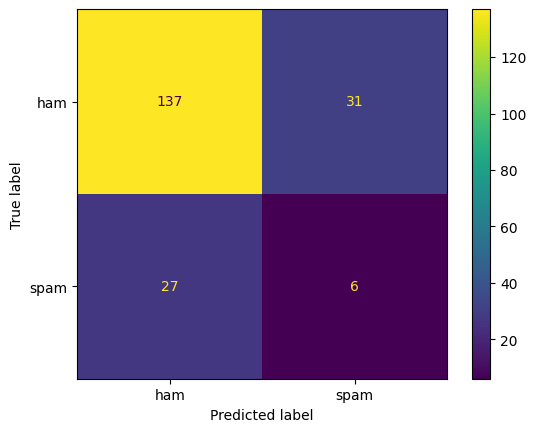


Spectral Clustering scores:
Mean Squared Error		0.279
Mean Absolute Error		0.279
False Positive Rate		0.848
False Negative Rate		0.167
Accuracy			0.721
Precision			0.152
Recall				0.152
F1				0.152


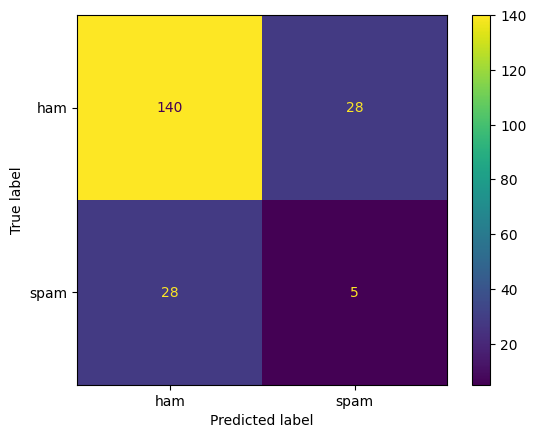


Support Vector scores:
Mean Squared Error		0.289
Mean Absolute Error		0.289
False Positive Rate		0.838
False Negative Rate		0.161
Accuracy			0.711
Precision			0.162
Recall				0.182
F1				0.171


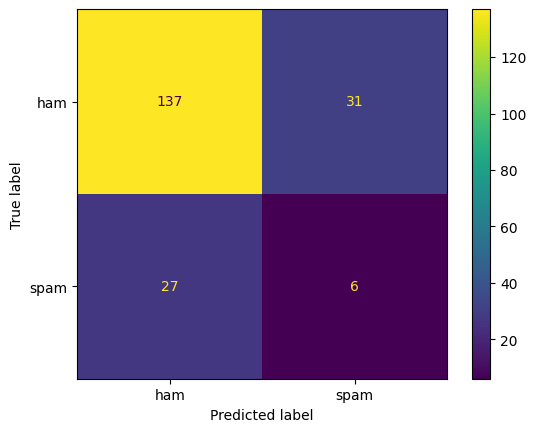


Voting Classifier scores:
Mean Squared Error		0.289
Mean Absolute Error		0.289
False Positive Rate		0.838
False Negative Rate		0.161
Accuracy			0.711
Precision			0.162
Recall				0.182
F1				0.171


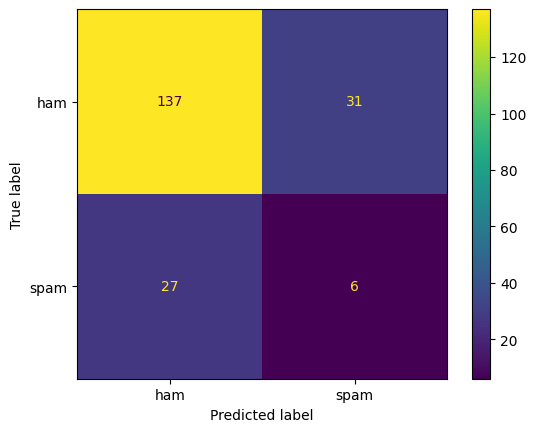


baseline scores:
Mean Squared Error		0.164
Mean Absolute Error		0.164
False Positive Rate		nan
False Negative Rate		0.196
Accuracy			0.836
Precision			0.000
Recall				0.000
F1				0.000


<ipython-input-168-e6c521d395cd>:13: RuntimeWarning: invalid value encountered in scalar divide
  "False Positive Rate\t": confusion[0][1]/confusion.sum(axis=0)[1],


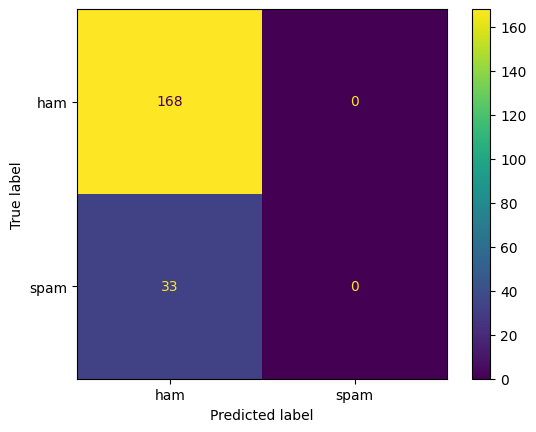

In [168]:
# get scoring metrics
scores = {}
scores_df = pd.DataFrame()
model_names = sorted(list(set(expected_and_predictions.columns) - {"actual"}))

for model_name in model_names:

    confusion = confusion_matrix(expected_and_predictions["actual"], expected_and_predictions[model_name])

    scores[model_name] = {
        "Mean Squared Error\t": mean_squared_error(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "Mean Absolute Error\t":  mean_absolute_error(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "False Positive Rate\t": confusion[0][1]/confusion.sum(axis=0)[1],
        "False Negative Rate\t": confusion[1][0]/confusion.sum(axis=1)[0],
        "Accuracy\t\t": accuracy_score(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "Precision\t\t": precision_score(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "Recall\t\t\t":  recall_score(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "F1\t\t\t":  f1_score(expected_and_predictions["actual"], expected_and_predictions[model_name])
    }

    print(model_name + " scores:")

    for metric, value in scores[model_name].items():
        print(metric + format(value))

    confusion_display = ConfusionMatrixDisplay(confusion, display_labels=["ham", "spam"])
    confusion_display.plot()
    plt.show()

    print()

In [188]:
mislabelled_sms = expected_and_predictions[model_names]
mislabelled_sms["mean pred class"] = mislabelled_sms.mean(axis=1)

mislabelled_cols = list(mislabelled_sms.columns)
col_names = list(mislabelled_sms.columns) + ["class", "text"]

# merge the df's
mislabelled_sms = pd.concat([mislabelled_sms, test], axis=1, ignore_index=True)

# rename the columns
mislabelled_sms.columns = list(mislabelled_cols) + list(test.columns)

# drop unnecessary cols
mislabelled_sms = mislabelled_sms[col_names]

In [203]:
mislabelled_sms = mislabelled_sms[abs(mislabelled_sms["class"] - mislabelled_sms["mean pred class"]) > 0.5]
mislabelled_sms

,Decision Tree,K Means,K Nearest Neighbor,Naive Bayes,Random Forest,Spectral Clustering,Support Vector,Voting Classifier,baseline,mean pred class,class,text
